In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bc import *
from hll import *
from hydro_adi_riemann import *
from hydro_adi_classic import *

# 1.1. A numerical solution to a Riemann problem

The problem we want to solve is defined as $\rho_L = 10^5$, $\rho_R = 1.24\times10^4$, $p_L = 1$, $p_R = 0.1$ and $u_L = u_R = 0$. \
Use the adiabatic (not the isothermal) versions of the solvers. Use 200 grid points between -100 and +100, and integrate until t = 5000.

## 1. Solve this problem and plot the results for $\rho(x)$, u(x), and p(x) at the final time (t = 5000).

In [2]:
# Define function for CFL condition
def CFL(dx, q):
    v_max = max(abs(q[1]/q[0]))
    return dx / v_max

# Define function for classic adiabatic integrator
def classic_adi_integrator(q_0, dx, dt, T):
    
    steps = int(T/dt) + 1
    q = np.zeros(( [steps+1, q_0.shape[0], q_0.shape[1]] ))
    
    # set initial conditions
    q[0] = q_0
    
    # loop over timesteps
    for i in range(steps):
        q[i+1] = hydro_adi_classic_one_timestep(q[i],dx,dt)
        
        # implement periodic boundary conditions
        implement_boundcond(q[i+1],bctype='fixed')
        
        # check CFL condition
        if not ( dt < CFL(dx, q[i+1]) ):
            print('CFL timestep condition not satisfied at timestep %i' %(i+1) )
        
    return q

# Define function for Riemann adiabatic integrator
def riemann_adi_integrator(q_0, dx, dt, T):
    
    steps = int(T/dt) + 1
    q = np.zeros(( [steps+1, q_0.shape[0], q_0.shape[1]] ))
    
    # set initial conditions
    q[0] = q_0
    
    # loop over timesteps
    for i in range(steps):
        q[i+1] = hydro_adi_riemann_one_timestep(q[i],dx,dt)
        
        # implement periodic boundary conditions
        implement_boundcond(q[i+1],bctype='fixed')
        
        # check CFL condition
        if not ( dt < CFL(dx, q[i+1]) ):
            print('CFL timestep condition not satisfied at timestep %i' %(i+1) )
        
    return q  

# Define function that gives rho, P, u values given a q
def convert(q):
    gamma = 7./5.              # adiabatic factor
    rho = q[:,0,:]             # density
    v = q[:,1,:]/rho           #velocity
    p = (gamma - 1)*(q[:,2,:]-(0.5*rho*v**2))
    
    return rho, v, p

In [3]:
# Define initial conditions and parameters

gamma = 7./5   # adiabatic constant

N = 200  # number of grid points
xmin, xmax = -100., 100.
dx = (xmax-xmin)/N
x = np.arange(xmin, xmax, dx) + dx/2   # take cells centers

T = 5000   # final integration time
Dt = 1.

indpos = np.where(x>0)[0]
indneg = np.where(x<0)[0]

# Initial rho
rho0 = np.zeros((len(x)))
rho0[indneg] = 10**5
rho0[indpos] = 1.24*10**4

# Initial v
v0 = np.zeros((len(x)))

# Initial p 
p0 = np.zeros((len(x)))
p0[indneg] = 1.
p0[indpos] = 0.1

q0 = np.array(( [rho0, rho0*v0, p0/(gamma-1)] ))

In [4]:
# Perform simulation 

q_classic = classic_adi_integrator(q0, dx, Dt, T)
q_riemann = riemann_adi_integrator(q0, dx, Dt, T)

# convert quantities
rho_cl, v_cl, p_cl = convert(q_classic)
rho_ri, v_ri, p_ri = convert(q_riemann)

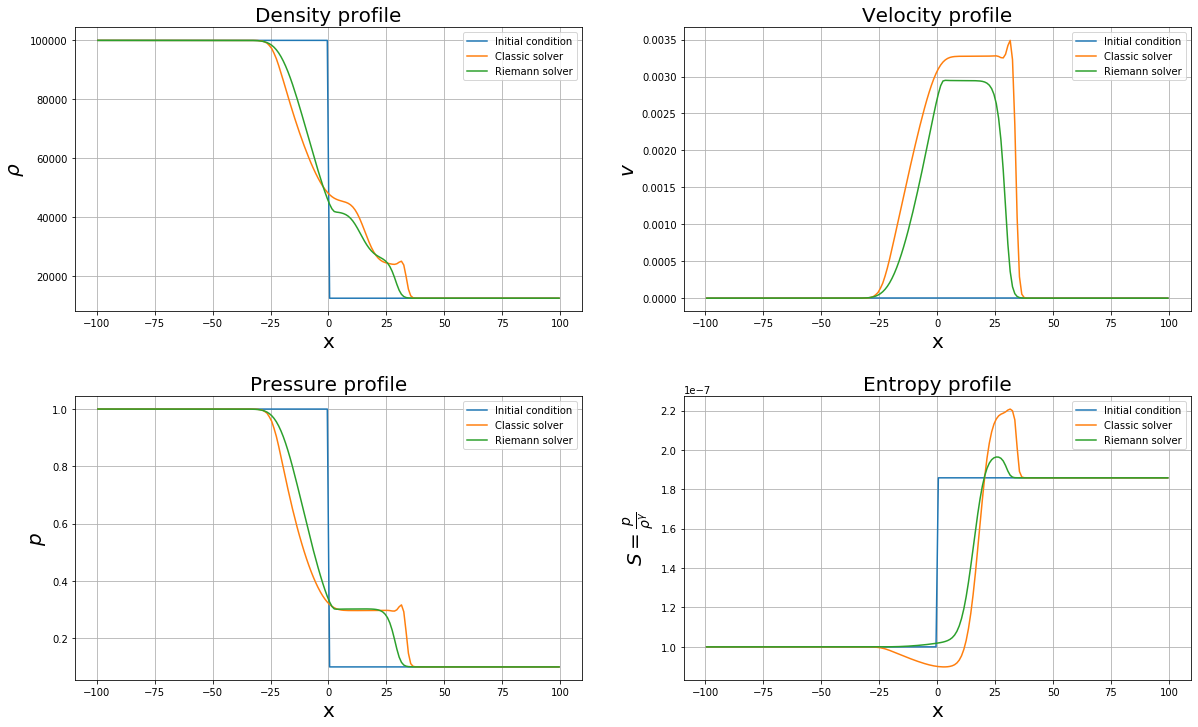

In [5]:
# Plot results

fig = plt.subplots(figsize=[20,12])
#plt.suptitle('Density profile', fontsize = 20)

plt.subplot(2,2,1)
plt.plot(x, rho0, label = 'Initial condition')
plt.plot(x, rho_cl[-1], label = 'Classic solver')
plt.plot(x, rho_ri[-1], label = 'Riemann solver')
plt.title('Density profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel(r'$\rho$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(x, v0, label = 'Initial condition')
plt.plot(x, v_cl[-1], label = 'Classic solver')
plt.plot(x, v_ri[-1], label = 'Riemann solver')
plt.title('Velocity profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel('$v$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(x, p0, label = 'Initial condition')
plt.plot(x, p_cl[-1], label = 'Classic solver')
plt.plot(x, p_ri[-1], label = 'Riemann solver')
plt.title('Pressure profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel('$p$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(x, p0/rho0**gamma, label = 'Initial condition')
plt.plot(x, p_cl[-1]/rho_cl[-1]**gamma, label = 'Classic solver')
plt.plot(x, p_ri[-1]/rho_ri[-1]**gamma, label = 'Riemann solver')
plt.title('Entropy profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel(r'$S = \frac{p}{\rho^\gamma}$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplots_adjust(hspace=.3)

plt.show(fig)

## 2. Compare the results between the classic and the HLL Riemann solver.

We notice that the profile resulting from the riemann solver is smoother; moreover, all "curves" are accentuated with the classic solver and there are some hints of instability.

## 3. Redo the problem with 10x higher spatial resolution.

In [6]:
N = 2000  # number of grid points
dx = (xmax-xmin)/N
x = np.arange(xmin, xmax, dx) + dx/2   # take cells centers

indpos = np.where(x>0)[0]
indneg = np.where(x<0)[0]

# Initial rho
rho0 = np.zeros((len(x)))
rho0[indneg] = 10**5
rho0[indpos] = 1.24*10**4

# Initial v
v0 = np.zeros((len(x)))

# Initial p 
p0 = np.zeros((len(x)))
p0[indneg] = 1.
p0[indpos] = 0.1

q0 = np.array(( [rho0, rho0*v0, p0/(gamma-1)] ))

# Perform simulation 
q_classic = classic_adi_integrator(q0, dx, Dt, T)
q_riemann = riemann_adi_integrator(q0, dx, Dt, T)

# convert quantities
rho_cl, v_cl, p_cl = convert(q_classic)
rho_ri, v_ri, p_ri = convert(q_riemann)

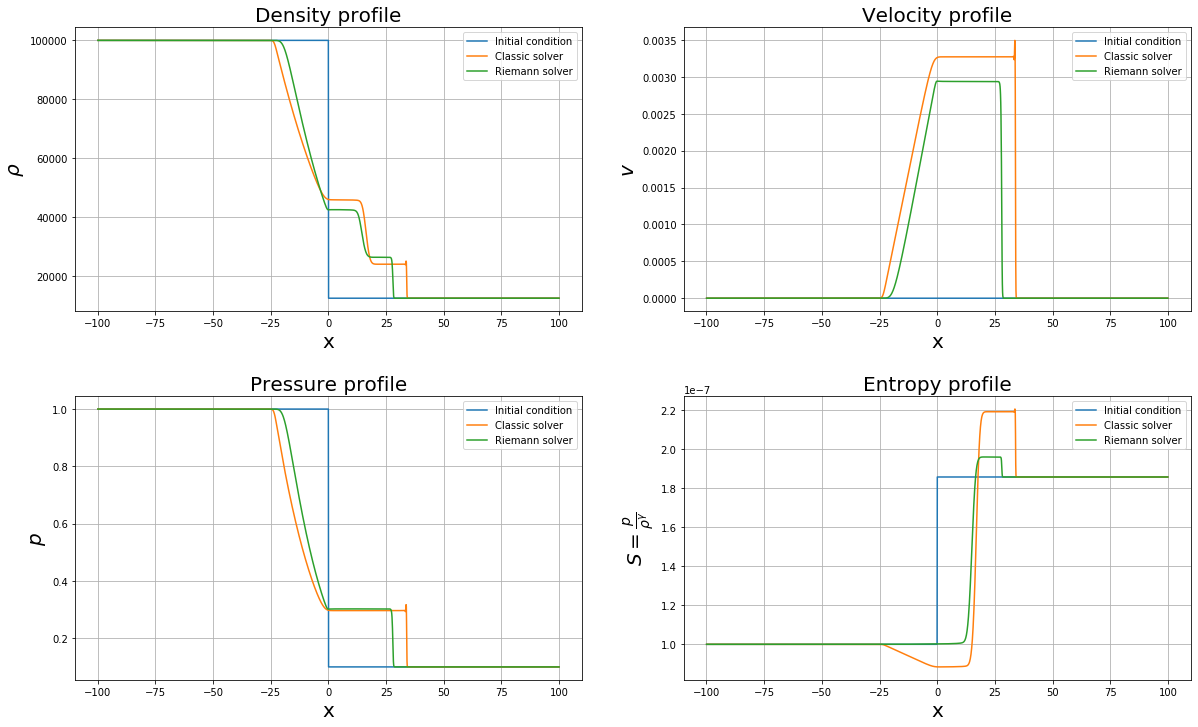

In [7]:
fig1 = plt.subplots(figsize=[20,12])
#plt.suptitle('Density profile', fontsize = 20)

plt.subplot(2,2,1)
plt.plot(x, rho0, label = 'Initial condition')
plt.plot(x, rho_cl[-1], label = 'Classic solver')
plt.plot(x, rho_ri[-1], label = 'Riemann solver')
plt.title('Density profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel(r'$\rho$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(x, v0, label = 'Initial condition')
plt.plot(x, v_cl[-1], label = 'Classic solver')
plt.plot(x, v_ri[-1], label = 'Riemann solver')
plt.title('Velocity profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel('$v$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(x, p0, label = 'Initial condition')
plt.plot(x, p_cl[-1], label = 'Classic solver')
plt.plot(x, p_ri[-1], label = 'Riemann solver')
plt.title('Pressure profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel('$p$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(x, p0/rho0**gamma, label = 'Initial condition')
plt.plot(x, p_cl[-1]/rho_cl[-1]**gamma, label = 'Classic solver')
plt.plot(x, p_ri[-1]/rho_ri[-1]**gamma, label = 'Riemann solver')
plt.title('Entropy profile', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel(r'$S = \frac{p}{\rho^\gamma}$', fontsize = 20)
plt.legend()
plt.grid()

plt.subplots_adjust(hspace=.3)

plt.show(fig1)

Here the profile is less smoother in both cases, presenting sharp edges as the initial profile, suggesting a better  simulation.

## 4. Explain the shape of the solution: where is the contact discontinuity, where is the expansion wave, and where is the shock wave?

In all the profiles the discontinuity on the right marks the shock wave, while the smoother one on the left represents a fan of rarefraction waves. On the density profile there is also a third discontinuity that marks the original contact of the two profiles; this same discontinuity is present on the left in the entropy profile.

# 1.2. Kelvin-Helmholtz instability

Unfortunately we were not able to make the downloadable code work, so we couldn't make this part.